# Sulphur Isotope Analysis
This notebook takes the raw $\mathrm{\delta^{34}S}$ (`d34S`) data from the mass spectrometer, and corrects the drift in the isotopic composition of the standards using linear interpolation. Then, the true $\mathrm{\delta^{34}S}$ of the samples are calculated relative to the standards.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy.interpolate as itp
import ipywidgets as wdg
from plotly_default import go # Custom graph style

In [2]:
# True d34S values of standards
true_std = {'NBS': 20.3,
            'S3' : -32.2}

standards = list(true_std.keys()) # list of standard names

In [3]:
# Read in MS data
isotope_df = pd.read_csv('./Data/S_isotopes_repeat.csv')
# isotope_df.head()

In [4]:
# Set up dictionary for average of each cluster of standards
cal_points = {std: {'avg_run':[], 'd34S_raw': [], 'd34S_corrected': []} for std in standards}

for standard in standards:
    # selects all groups of standard
    for sample_group in range(isotope_df.group.min(), isotope_df.group.max()+1, 2):
        group_df = isotope_df[(isotope_df.group == sample_group) & (isotope_df.name == standard)]
        # caluclate average run number
        cal_points[standard]['avg_run'].append(group_df.run_no.mean())
        # calculate average d34S
        cal_points[standard]['d34S_raw'].append(group_df.d34S_raw.mean())
        # If this all works, these d34S values should correct to the true values
        cal_points[standard]['d34S_corrected'].append(true_std[standard])

In [5]:
# Interpolate standard d34S
for standard in standards:
    # Interpolate linearly between calibration points
    itp_fn = itp.interp1d(x=cal_points[standard]['avg_run'],
                          y=cal_points[standard]['d34S_raw'],
                          fill_value='extrapolate')
    
    # Evaluate interpolation function at each data point
    itp_values = itp_fn(isotope_df.run_no)
    isotope_df[standard+'_itp'] = itp_values

In [6]:
Delta_true = true_std['NBS'] - true_std['S3']

d34Ss_corrected = [] # empty list to store corrected d34S

# Correct isotope values
for sample in isotope_df.iterrows():
    Delta_NBS = sample[1].NBS_itp - sample[1].d34S_raw
    Delta_S3 = sample[1].d34S_raw - sample[1].S3_itp
    Delta_S3_corrected = Delta_S3 * Delta_true / (Delta_NBS + Delta_S3)
    d34Ss_corrected.append(true_std['S3'] + Delta_S3_corrected)
    
isotope_df['d34S_corrected'] = d34Ss_corrected

In [7]:
# Calculate errors
std_NBS = isotope_df[isotope_df.name == 'NBS'].d34S_raw.std() # σ of NBS samples. Normalised n-1 by default.
std_S3 = isotope_df[isotope_df.name == 'S3'].d34S_raw.std()

av_err = (std_NBS + std_S3)/2

isotope_df['d34S_err'] = av_err

In [12]:
isotope_df.head(20)

,run_no,name,data_type,group,height,d34S_raw,NBS_itp,S3_itp,d34S_corrected,d34S_err
0,1,NBS,standard,0,NaN,21.912,21.979918,-25.862503,20.225470,0.317056
1,2,NBS,standard,0,NaN,22.039,21.985351,-25.877570,20.358847,0.317056
2,3,NBS,standard,0,NaN,21.850,21.990784,-25.892636,20.145643,0.317056
3,4,NBS,standard,0,NaN,22.007,21.996216,-25.907702,20.311818,0.317056
4,5,NBS,standard,0,NaN,22.099,22.001649,-25.922768,20.406646,0.317056
5,6,NBS,standard,0,NaN,22.054,22.007082,-25.937834,20.351376,0.317056
6,8,S3,standard,0,NaN,-25.488,22.017947,-25.967967,-31.674882,0.317056
7,9,S3,standard,0,NaN,-26.463,22.023380,-25.983033,-32.724894,0.317056
8,10,KC-2-2,normal,1,1.68,-10.728,22.028813,-25.998099,-15.507688,0.317056
9,12,KC-2-5,normal,1,5.16,-14.937,22.039678,-26.028232,-20.086104,0.317056


In [9]:
errorbar = dict(type='constant', value=av_err, thickness=1.5)



@wdg.interact(corrected=False)
def plot_std_graph(corrected):
    
    std_plot = go.FigureWidget()
    
    if corrected:
        plot_col = 'd34S_corrected'
    else:
        plot_col = 'd34S_raw'

    for standard, colour in zip(standards, ['RoyalBlue', 'green']):
        std_df = isotope_df[isotope_df.name==standard]
        std_plot.add_trace(go.Scatter(x=std_df.run_no, y=std_df[plot_col],
                                      error_y = errorbar,
                                      name=standard, marker_color=colour))

        std_plot.add_trace(go.Scatter(x=cal_points[standard]['avg_run'],
                                      y=cal_points[standard][plot_col],
                                      name=standard+' (average)',
                                      marker_color=colour, marker_symbol='square',
                                      opacity=0.5))

        std_plot.add_hline(true_std[standard], line_width=2, line_color=colour, line_dash='dash')

    std_plot.update_layout(xaxis_title = 'Run number',
                           xaxis_rangemode = 'tozero',
                           yaxis_title = 'δ<sup>34</sup>S / ‰')   

    sample_isotopes=isotope_df[(isotope_df.data_type=='normal') | (isotope_df.data_type=='duplicate')]
    std_plot.add_trace(go.Scatter(x=sample_isotopes.run_no, y=sample_isotopes[plot_col],
                                  error_y = errorbar,
                                  name='Samples', marker_color='GoldenRod',
                                  mode='markers+lines'))

    
    std_plot.show()

interactive(children=(Checkbox(value=False, description='corrected'), Output()), _dom_classes=('widget-interac…

In [13]:
isotope_df.sort_values('height', inplace=True)

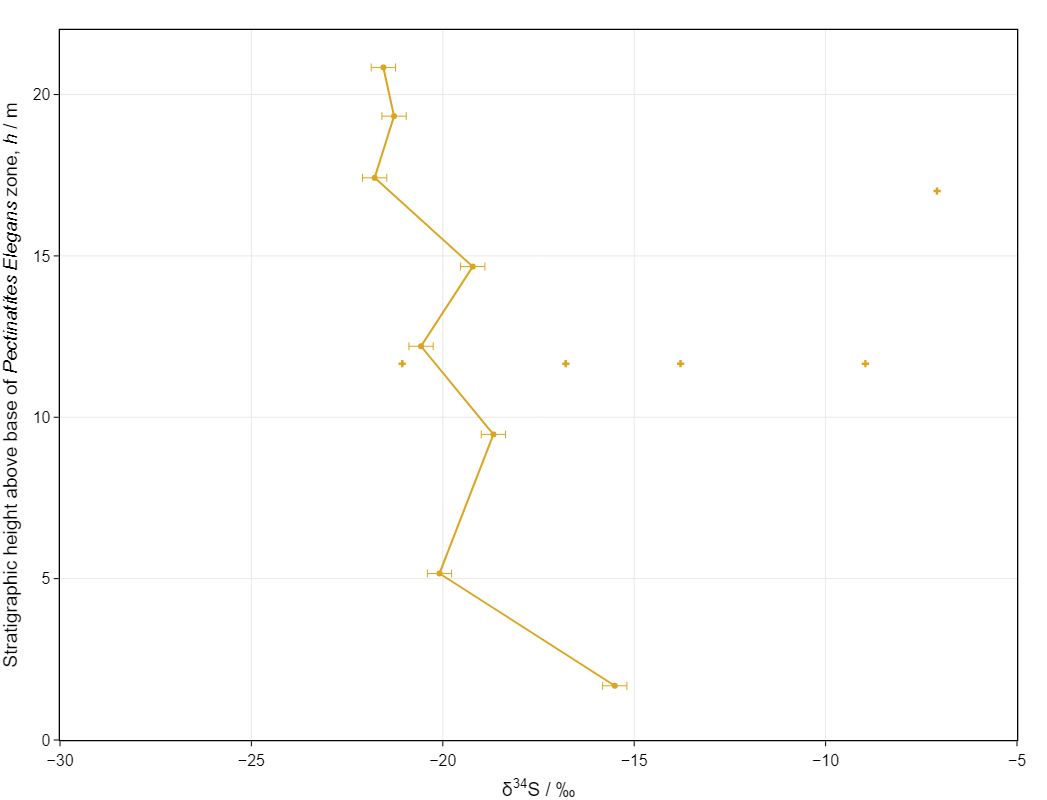

In [17]:
# plot vertical stratigraphic log
log_data = isotope_df[isotope_df.data_type=='normal']
extra_data = isotope_df[isotope_df.data_type=='duplicate']

S_log = go.Figure()

S_log.add_trace(go.Scatter(x=log_data.d34S_corrected,
                           y=log_data.height,
                           text=log_data.name,
                           error_x_array=log_data.d34S_err,
                           error_x_thickness=1,
                           mode='markers+lines',
                           marker_color='GoldenRod'))

S_log.add_trace(go.Scatter(x=extra_data.d34S_corrected,
                           y=extra_data.height,
                           text=extra_data.name,
                           mode='markers',
                           marker_color='GoldenRod',
                           marker_symbol='cross'))

S_log.update_layout(xaxis_title='δ<sup>34</sup>S / ‰',
                    yaxis_title='Stratigraphic height above base of <i>Pectinatites Elegans</i> zone, <i>h</i> / m',
                    xaxis_range=[-30,-5],
                    yaxis_range=[0,22],
                    showlegend=False,
                    width=400,
                    height=800)

#S_log.write_image('Images/S_log.svg')
#S_log.write_html('Interactives/S_log.html', include_plotlyjs='cdn')
#S_log.write_image('Images/S_log.png', scale=3)

S_log.show()

In [11]:
isotope_df.to_csv('Data/S_isotopes_processed_repeats.csv')